In [1]:
import graphlearning as gl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import torch
import scipy.sparse as sp
from scipy.sparse import coo_matrix, triu

from tqdm.notebook import tqdm

In [2]:
"""create two moons dataset and knn graph (k=10). with gaussian weights """
X, labels = datasets.make_moons(n_samples=1000, noise=0.1)
W = gl.weightmatrix.knn(X, k=10, kernel='gaussian')

# drop self-loops, keep each undirected edge once
W.setdiag(0); W.eliminate_zeros()
C = sp.triu(W, k=1).tocoo()

src = torch.from_numpy(C.row)
dst = torch.from_numpy(C.col)
w   = torch.from_numpy(C.data)
X = torch.tensor(X)

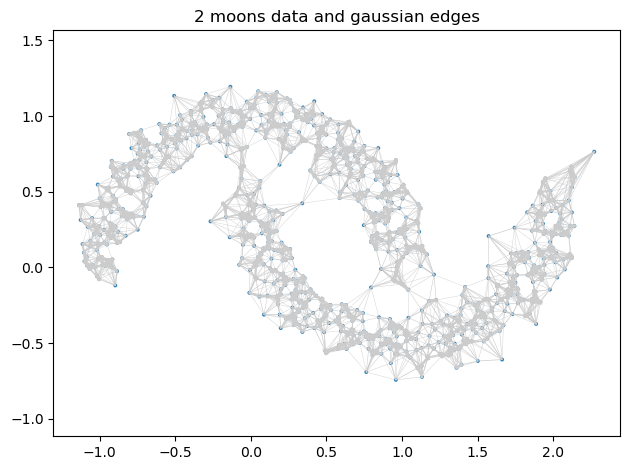

In [3]:
"""plot data points """
plt.scatter(X[:, 0], X[:, 1], s=8, edgecolors='none', alpha=0.9)

"""plot edges """
wmax = w.max()
for i, j, w0 in zip(C.row, C.col, C.data):
    lw = 0.25 + 2.75 * (w0 / wmax)            # scale line width by weight
    plt.plot([X[i,0], X[j,0]], [X[i,1], X[j,1]], color='0.8', linewidth=lw)

plt.title('2 moons data and gaussian edges')
plt.axis('equal'); plt.tight_layout(); plt.show()

In [4]:
def project_l2(q, r):
    """Project each edge-vector row of q onto an ell_2 ball with (per-edge) radius r."""
    eps = 1e-8
    nrm = q.norm(dim=-1, keepdim=True).clamp_min(eps)
    return q * torch.minimum(torch.ones_like(nrm), r.view(-1,1) / nrm)

def divergence(p, src, dst, n):
    """Graph divergence: add +p_e at node i=src[e] and -p_e at node j=dst[e]."""
    d = p.size(-1)
    out = torch.zeros(n, d)
    out.index_add_(0, src,  p)
    out.index_add_(0, dst, -p)
    return out

def energy(U, X, src, dst, w, lam):
    """Objective: 0.5*||U-X||_2^2  +  lam * sum_e w_e ||U_i - U_j||_2."""
    data = 0.5 * (U - X).pow(2).sum()
    tv = (U[src] - U[dst]).norm(dim=-1).mul(w).sum()
    return data + lam * tv

def primal_dual(X, src, dst, w, lam=1.0, iters=200, tau=0.35, sigma=0.35):
    """Main iterations """
    n, d = X.shape
    m = src.numel()
    U = X.clone()
    P = torch.zeros(m, d)
    r = lam * w
    losses = []
    for _ in tqdm(range(iters)):
        # dual step (edge-wise projection onto norm ball with radius \lambda w)
        diff = U[src] - U[dst]
        P = project_l2(P + tau * diff, r)
        # primal step (node update with divergence of dual)
        U = (U + sigma * (X - divergence(P, src, dst, n))) / (1.0 + sigma)

        losses.append(energy(U, X, src, dst, w, lam).item())
    return U.detach(), losses

In [5]:
def plot_results(X, U, losses, point_size=8):
    """Plot the loss curve and a grayscale scatter of the smoothed solution U."""
    fig = plt.figure(figsize=(10,4))

    # loss curve
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(range(1, len(losses)+1), losses)
    ax1.set_xlabel('iter'); ax1.set_ylabel('objective'); ax1.set_title('Loss')

    # smoothed embedding
    ax2 = fig.add_subplot(1,2,2)

    ax2.scatter(X[:, 0], X[:, 1], s=8, edgecolors='none', alpha=0.5, label='original data')
    ax2.scatter(U[:,0].cpu(), U[:,1].cpu(), s=point_size, alpha=0.9, c='0.4', label='clustered data')
    ax2.set_aspect('equal'); ax2.set_title('Smoothed / clustered U'); ax2.legend()

    plt.tight_layout(); plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

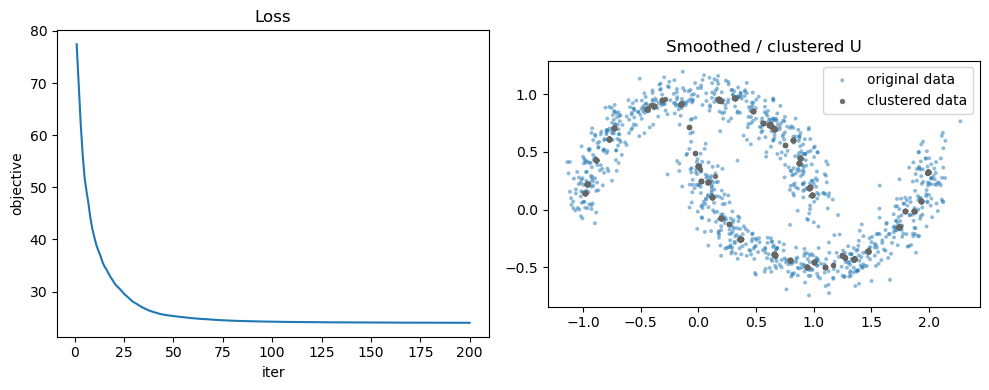

In [7]:
U, losses = primal_dual(X.float(), src, dst, w.float(), lam=2.0, iters=200)
plot_results(X, U, losses)